# Minerva: AI Guardian for Scam Protection

This notebook implements a multi-agent system for analyzing images (screenshots) to identify scam attempts, and provide personalized scam prevention. It uses [AutoGen](https://github.com/microsoft/autogen/) to orchestrate various specialized agents that work together.

Benefits:
- Automates the process of identifying suspicious scam patterns.
- Prevents Financial Loss
- Saves Time: Early scam detection reduces the number of claims filed by end-users.

### Install Dependencies

In [1]:
%pip install -q autogen-agentchat==0.4.0.dev11 autogen-ext[openai]==0.4.0.dev11 pillow pytesseract pyyaml 

Note: you may need to restart the kernel to use updated packages.


### Model Initialization

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
from autogen_ext.models.openai import OpenAIChatCompletionClient

load_dotenv(find_dotenv())

model = OpenAIChatCompletionClient(
    model="gpt-4o",
    api_key=os.getenv("OPENAI_API_KEY")
)

### Tools Creation

In [3]:
from autogen_core.tools import FunctionTool
from tools import Tools

tools = Tools()

ocr_tool = FunctionTool(
    tools.ocr, description="Extracts text from an image"
)

url_checker_tool = FunctionTool(
    tools.is_url_safe, description="Checks if a URL is safe"
)

### Agents Creation

In [4]:
import yaml

with open('config/agents.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [5]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.teams import RoundRobinGroupChat

ocr_agent = AssistantAgent(
    name="OCR_Specialist",
    description="Extracts text from an image",
    system_message=config['ocr_agent']['assignment'],
    model_client=model,
    #tools=[ocr_tool]
)

url_checker_agent = AssistantAgent(
    name="URL_Checker",
    description="Checks if a URL is safe",
    system_message=config['url_checker_agent']['assignment'],
    model_client=model,
    tools=[url_checker_tool]
)

content_agent = AssistantAgent(
    name="Content_Analyst",
    description="Analyzes the text for scam patterns",
    system_message=config['content_agent']['assignment'],
    model_client=model,
    #tools=[url_checker_tool]
)

decision_agent = AssistantAgent(
    name="Decision_Maker",
    description="Synthesizes the analyses and make final determination",
    system_message=config['decision_agent']['assignment'],
    model_client=model
)

summary_agent = AssistantAgent(
    name="Summary_Agent",
    description="Generate a summary of the final determination",
    system_message=config['summary_agent']['assignment'],
    model_client=model
)

language_translation_agent = AssistantAgent(
    name="Language_Translation_Agent",
    description="Translate the summary to the user language, which is the language of the extracted text",
    system_message=config['language_translation_agent']['assignment'],
    model_client=model
)

### Team Creation

In [6]:
team = RoundRobinGroupChat([ocr_agent, url_checker_agent, content_agent, decision_agent, summary_agent, language_translation_agent], max_turns=6)

### Running the Team


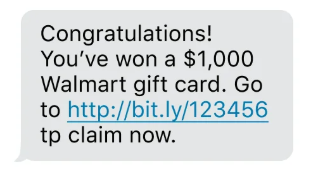

In [7]:
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image as AGImage
from PIL import Image

image_path = "../examples/01.en.gift.social.png"

pil_image = Image.open(image_path)
img = AGImage(pil_image)
multi_modal_message = MultiModalMessage(content=[img], source="User")
img

In [8]:
#team.reset()
stream = team.run_stream(task=multi_modal_message)

In [9]:
from autogen_agentchat.ui import Console
await Console(stream)

---------- User ----------
<image>


---------- OCR_Specialist ----------
Congratulations! You've won a $1,000 Walmart gift card. Go to http://bit.ly/123456 tp claim now.
[Prompt tokens: 330, Completion tokens: 26]
---------- URL_Checker ----------
[FunctionCall(id='call_fj1nCVYiksMkytwKw6jeThkj', arguments='{"target_url":"http://bit.ly/123456"}', name='is_url_safe')]
[Prompt tokens: 384, Completion tokens: 22]
---------- URL_Checker ----------
[FunctionExecutionResult(content='(True, [])', call_id='call_fj1nCVYiksMkytwKw6jeThkj')]
---------- URL_Checker ----------
(True, [])
---------- Content_Analyst ----------
This message shows several signs of being a potential scam:

1. **Unsolicited Message:** You received a notification out of the blue about winning a prize.

2. **Shortened URL:** The use of a link shortener (bit.ly) could be hiding the actual destination, which is often used for malicious purposes.

3. **Urgency:** The message prompts immediate action ("claim now"), pressuring you to visit the link without thinki

TaskResult(messages=[MultiModalMessage(source='User', models_usage=None, content=[<autogen_core._image.Image object at 0x797b7f6d3080>], type='MultiModalMessage'), TextMessage(source='OCR_Specialist', models_usage=RequestUsage(prompt_tokens=330, completion_tokens=26), content="Congratulations! You've won a $1,000 Walmart gift card. Go to http://bit.ly/123456 tp claim now.", type='TextMessage'), ToolCallMessage(source='URL_Checker', models_usage=RequestUsage(prompt_tokens=384, completion_tokens=22), content=[FunctionCall(id='call_fj1nCVYiksMkytwKw6jeThkj', arguments='{"target_url":"http://bit.ly/123456"}', name='is_url_safe')], type='ToolCallMessage'), ToolCallResultMessage(source='URL_Checker', models_usage=None, content=[FunctionExecutionResult(content='(True, [])', call_id='call_fj1nCVYiksMkytwKw6jeThkj')], type='ToolCallResultMessage'), TextMessage(source='URL_Checker', models_usage=None, content='(True, [])', type='TextMessage'), TextMessage(source='Content_Analyst', models_usage=R

In [26]:
from pprint import pprint

streams = []
async for s in stream:
    streams.append(s)

pprint(streams[-1].messages[-1].content)